In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import cv2
import numpy as np
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import pickle
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from IPython import embed
import timm
import torch.nn.functional as F
import torchvision.utils as utils
from torchsummary import summary


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model_path = '/content/drive/MyDrive/792_model/celebdf_model_4_epochs_94acc.pt'
checkpoint = torch.load(model_path)
# checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
target_class = 0

In [6]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2).to(device)

In [7]:
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [8]:
state_dict = model.state_dict()

In [9]:
# Access each layer as a dictionary
# for key in state_dict.items():
#     print(key)

state_dict.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'block1.skip.weight', 'block1.skipbn.weight', 'block1.skipbn.bias', 'block1.skipbn.running_mean', 'block1.skipbn.running_var', 'block1.skipbn.num_batches_tracked', 'block1.rep.0.conv1.weight', 'block1.rep.0.pointwise.weight', 'block1.rep.1.weight', 'block1.rep.1.bias', 'block1.rep.1.running_mean', 'block1.rep.1.running_var', 'block1.rep.1.num_batches_tracked', 'block1.rep.3.conv1.weight', 'block1.rep.3.pointwise.weight', 'block1.rep.4.weight', 'block1.rep.4.bias', 'block1.rep.4.running_mean', 'block1.rep.4.running_var', 'block1.rep.4.num_batches_tracked', 'block2.skip.weight', 'block2.skipbn.weight', 'block2.skipbn.bias', 'block2.skipbn.running_mean', 'block2.skipbn.running_var', 'block2.skipbn.num_batches_tracked', 'block2.rep.1.conv1.weight', 'block2.rep.1.poi

In [10]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             864
       BatchNorm2d-2           [-1, 32, 63, 63]              64
              ReLU-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,432
       BatchNorm2d-5           [-1, 64, 61, 61]             128
              ReLU-6           [-1, 64, 61, 61]               0
            Conv2d-7           [-1, 64, 61, 61]             576
            Conv2d-8          [-1, 128, 61, 61]           8,192
   SeparableConv2d-9          [-1, 128, 61, 61]               0
      BatchNorm2d-10          [-1, 128, 61, 61]             256
             ReLU-11          [-1, 128, 61, 61]               0
           Conv2d-12          [-1, 128, 61, 61]           1,152
           Conv2d-13          [-1, 128, 61, 61]          16,384
  SeparableConv2d-14          [-1, 128,

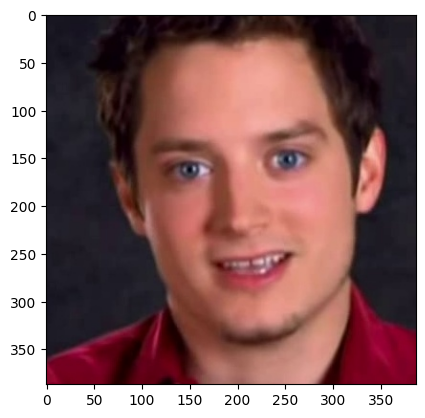

In [11]:
image_path = '/content/drive/MyDrive/Celeb_DF_dataset/Celeb-real-images/000061.jpg'   

image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [12]:
image.shape

(387, 387, 3)

In [13]:
def preprocess_image(cv2im, resize_im=True):
    if resize_im:
        cv2im = cv2.resize(cv2im, (128, 128))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)
    im_as_ten = torch.from_numpy(im_as_arr).float()
    print(im_as_ten.shape)
    # Add one more channel to the beginning. Tensor shape = 1,3,128,128
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var, im_as_ten

In [14]:
image_prep, im_as_ten = preprocess_image(image)
image_prep = image_prep.to(device)
im_as_ten = im_as_ten.to(device)

torch.Size([3, 128, 128])


(32, 63, 63)


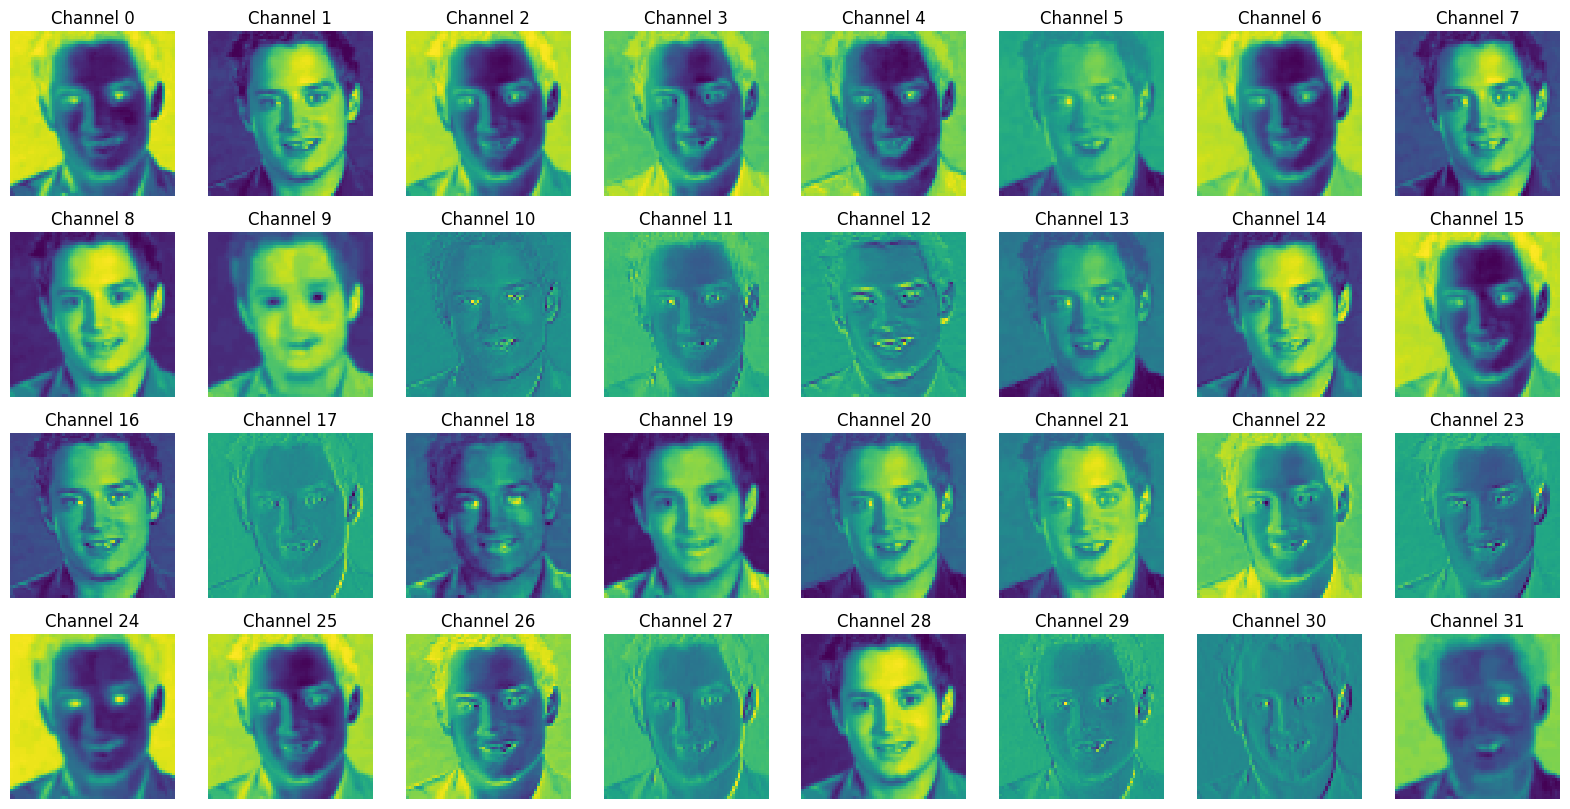

In [15]:
with torch.no_grad():
    # get the activations of the first convolutional layer
    conv1_activations = model.conv1(im_as_ten)
    conv1_weights = model.conv1.weight.data

    conv1_activations = conv1_activations.detach().cpu().numpy().squeeze()
    print(conv1_activations.shape)

    fig = plt.figure(figsize=(20, 10))

    for i, channel in enumerate(range(0, conv1_activations.shape[0])):
        sub_fig = fig.add_subplot(4, 8, i+1)
        conv1_activations_channel = conv1_activations[channel, :, :]
        sub_fig.imshow(conv1_activations_channel, interpolation='none')
        sub_fig.set_title(f'Channel {channel}')
        sub_fig.set_axis_off()

    plt.show()

In [16]:
activation = {}

def getActivation(name):
  def hook(model, input, output):
      activation[name] = output.detach()
  return hook

In [17]:
layers = list(model.children())
print(len(layers))
sep_conv2 = list(layers[7].children())[2][4]

26


In [18]:
inner_layers = torch.nn.Sequential(*list(layers[7].children())[1:])
inner_layers[1][4]

SeparableConv2d(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
  (pointwise): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [19]:
conv_layer = model.conv1
conv_layer

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

In [20]:
model_list = list(model.children())
h1 = sep_conv2.register_forward_hook(getActivation('sep_conv2'))

out = model(im_as_ten)

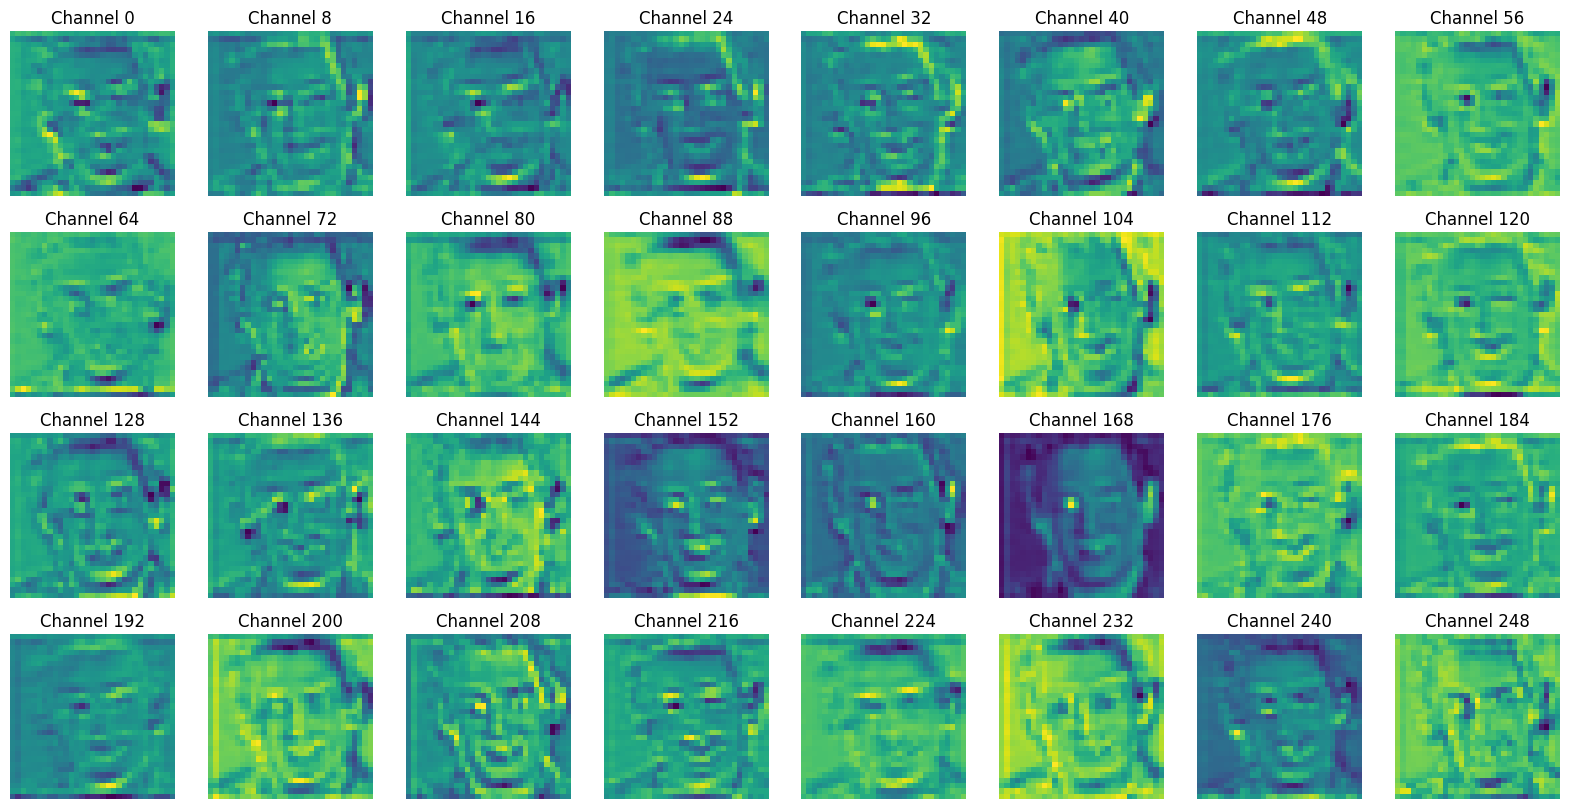

In [21]:
fig = plt.figure(figsize=(20, 10))

with torch.no_grad():
  for i, channel in enumerate(range(0, activation['sep_conv2'].shape[1], 8)):
      sub_fig = fig.add_subplot(4, 8, i+1)
      activation_layer = activation['sep_conv2'][0]
      conv1_activations_channel = activation_layer[channel, :, :].cpu()
      sub_fig.imshow(conv1_activations_channel, interpolation='none')
      sub_fig.set_title(f'Channel {channel}')
      sub_fig.set_axis_off()

  plt.show()


In [22]:
out

tensor([[-103.2354,   36.5337]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [65]:
class CamExtractor():
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_name, module in self.model._modules.items():
          print(module_name)

          if module_name == 'fc':
              x = module(x)
              # x = torch.sigmoid(x)
              return conv_output, x

          x = module(x)  # Forward

          if module_name == self.target_layer:
              x.register_hook(self.save_gradient)
              conv_output = x  # Save the convolution output on that layer

        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)

        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        # x = self.model.fc(x)
        return conv_output, x

In [114]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)

        if target_index is None:
            target_index = np.argmax(model_output.cpu().data.numpy())

        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_index] = 1
        print(one_hot_output)
        # Zero grads
        self.model.fc.zero_grad()
        # self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output.to(device), retain_graph=True)
        print(model_output)

        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        print(guided_gradients.shape)
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        # Take averages for each gradient
        weights = np.mean(guided_gradients, axis=(1, 2))
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        return cam

In [142]:
grad_cam = GradCam(model, target_layer='conv1')

In [143]:
# target_class = 0

In [144]:
cam = grad_cam.generate_cam(image_prep)

conv1
bn1
act1
conv2
bn2
act2
block1
block2
block3
block4
block5
block6
block7
block8
block9
block10
block11
block12
conv3
bn3
act3
conv4
bn4
act4
global_pool
fc
tensor([[0., 1.]])
tensor([[-103.2354,   36.5337]], device='cuda:0', grad_fn=<ViewBackward0>)
(32, 63, 63)


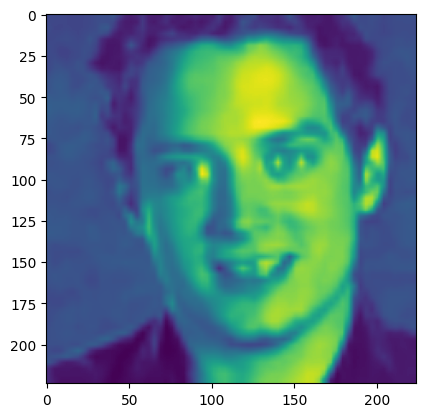

In [145]:
plt.imshow(cam)

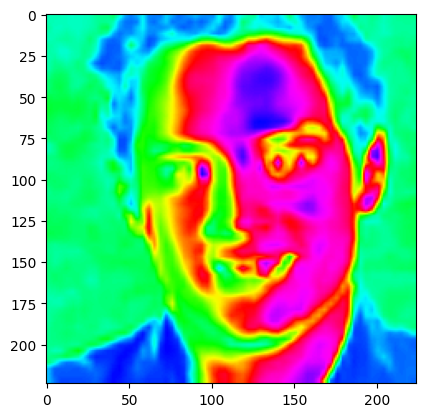

In [146]:
activation_heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
plt.imshow(activation_heatmap)

In [147]:
org_img = cv2.resize(image, (128, 128))

In [148]:
activation_heatmap = cv2.resize(activation_heatmap, (128, 128))

In [149]:
img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
np_img_heat = np.uint8(255 * img_with_heatmap)

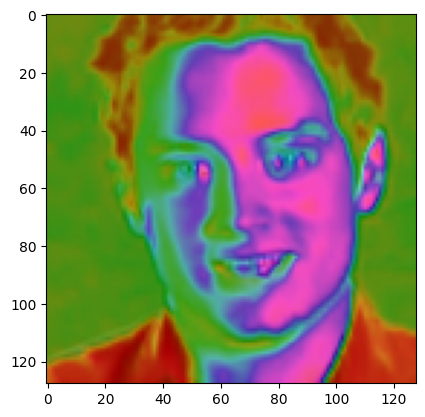

In [150]:
plt.imshow(cv2.cvtColor(np_img_heat, cv2.COLOR_BGR2RGB))